# Comenzamos importando

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import keras_nlp
from sklearn.model_selection import train_test_split

2025-08-15 18:12:00.965677: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755281521.214390      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755281521.286170      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Carga y exploración de datos

In [2]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")


In [3]:
train_df.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [4]:
train_df.shape

(7613, 5)

In [5]:
train_df.isnull().sum().sort_values(ascending=False)

location    2533
keyword       61
id             0
text           0
target         0
dtype: int64

### Muchos nulos, por lo que eliminaremos 'location'

In [6]:
train_df = train_df.drop(columns=['location'])
train_df['keyword'] = train_df['keyword'].fillna('None')

# Separar características y etiquetas

In [7]:
texts = train_df['text'].astype('str')
labels = train_df['target'].values

# Dividimos en train y test

In [8]:
X_train,X_valid,y_train,y_valid = train_test_split(
    texts,labels,test_size=0.2,random_state=42
)

# El siguiente paso es vectorizar/tokenizar los textos para que el modelo de Keras pueda procesarlos

In [9]:
# Definimos la longitud máxima del texto
max_length = 100

# Creamos el vectorizador de texto
vectorizer = keras.layers.TextVectorization(
    max_tokens=20000,# numero maximo de palabras 
    output_mode='int',# convierte palabras en enteros
    output_sequence_length=max_length
)

# Adaptamos vectorizador a datos de entrenamiento
vectorizer.adapt(X_train)

# Vectorizar los textos de test y train
X_train_v = vectorizer(X_train)
X_valid_v = vectorizer(X_valid)
# Extraer la columna de texto
X_test = test_df['text'].values

# Vectorizar los textos de test
X_test_v = vectorizer(X_test)

2025-08-15 18:12:19.366631: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# Definimos modelo tipo Transformer

In [10]:
# Parametros de nuestro modelo
vocab_size=20000 # igual que max_tokens
embedding_dim = 128
num_heads = 4
ff_dim = 128
num_classes = 2 # para tener target 0/1

# Capa de entrada
inputs = keras.Input(shape=(None,), dtype="int32") # shape=(None,) significa que la longitud de la secuencia puede variar.

# Capa de embedding
x = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)
 # Convierte cada entero (token) en un vector de dimensión embedding_dim

# Capa Transformer
x = keras.layers.MultiHeadAttention(num_heads=num_heads,key_dim=embedding_dim)(x, x)

# Cada “cabeza” de atención aprende a fijarse en partes distintas de la secuencia.
# x, x indica que estamos comparando la secuencia consigo misma (self-attention).
# Ayuda al modelo a captar relaciones entre palabras sin importar su posición

x = keras.layers.GlobalAveragePooling1D()(x)
# Reduce toda la secuencia de vectores a un solo vector promedio.
# Sirve para resumir toda la información de la frase en un solo vector fijo

# Totalmente conectado
x = keras.layers.Dense(ff_dim,activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(num_classes,activation="softmax")(x)

# Modelo 
model = keras.Model(inputs=inputs,outputs=outputs)
# Genera probabilidades para cada clase (en tu caso 0 o 1).
# softmax asegura que las salidas sumen 1 y sean interpretables como probabilidades.

# Compilacion
model.compile(
    optimizer="adam",
    loss= "sparse_categorical_crossentropy",
    metrics=["accuracy"]
    
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 128) │  2,560,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 128) │    263,808 │ embedding[0][0],  │
│ (MultiHeadAttentio… │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │        258 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,840,578 (10.84 MB)

 Trainable params: 2,840,578 (10.84 MB)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento, evaluacion y prediccion

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Definimos early stopping
early_stop = EarlyStopping(
    monitor='val_loss',     # observa la pérdida de validación
    patience=3,             # espera 3 épocas antes de detener
    restore_best_weights=True  # devuelve los pesos del mejor modelo
)

# Entrenamiento
history = model.fit(
    X_train_v, y_train,
    validation_data=(X_valid_v, y_valid),
    batch_size=32,
    epochs=5,
    callbacks=[early_stop]  
)


Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 37s 173ms/step - accuracy: 0.5625 - loss: 0.6869 - val_accuracy: 0.5739 - val_loss: 0.6864
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 168ms/step - accuracy: 0.6141 - loss: 0.6417 - val_accuracy: 0.8011 - val_loss: 0.4864
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 31s 164ms/step - accuracy: 0.8638 - loss: 0.3395 - val_accuracy: 0.7781 - val_loss: 0.6159
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 31s 163ms/step - accuracy: 0.9340 - loss: 0.1898 - val_accuracy: 0.7787 - val_loss: 0.7795
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 165ms/step - accuracy: 0.9696 - loss: 0.0792 - val_accuracy: 0.7708 - val_loss: 0.7762


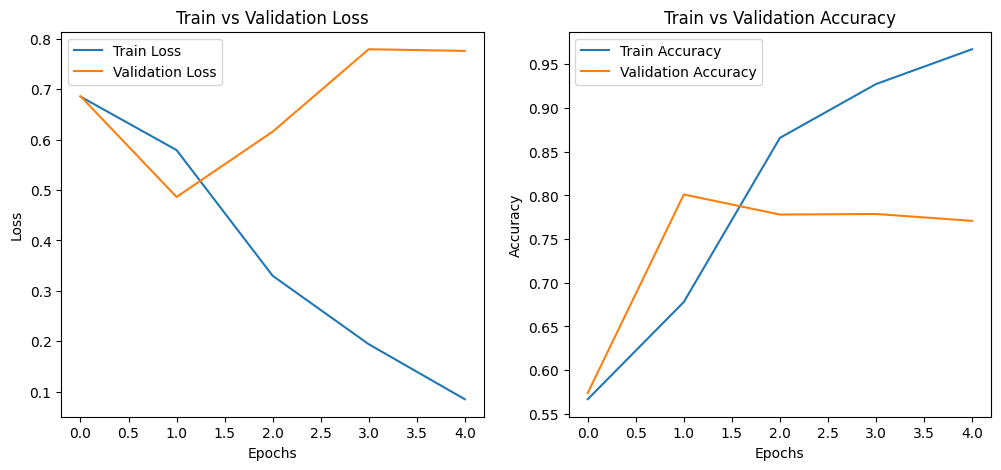

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.92      0.84       874
           1       0.85      0.64      0.73       649

    accuracy                           0.80      1523
   macro avg       0.82      0.78      0.79      1523
weighted avg       0.81      0.80      0.80      1523

Confusion Matrix:

[[803  71]
 [232 417]]


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

#  Graficar pérdida y precisión
plt.figure(figsize=(12,5))

# Pérdida
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Precisión
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.show()

#  Predicciones sobre el conjunto de validación
y_pred = model.predict(X_valid_v)
# Si tus salidas son probabilidades con softmax:
y_pred_classes = np.argmax(y_pred, axis=1)  # devuelve 0 o 1

from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n")
print(classification_report(y_valid, y_pred_classes))

print("Confusion Matrix:\n")
print(confusion_matrix(y_valid, y_pred_classes))



# Terminamos

In [13]:
# Asegúrate de vectorizar también los textos de test
X_test_v = vectorizer(X_test)  # X_test es tu dataframe de test['text']

# Predecir probabilidades para cada clase
y_test_pred_probs = model.predict(X_test_v)

# Elegir la clase con mayor probabilidad
y_test_pred_classes = y_test_pred_probs.argmax(axis=1)

# Crear DataFrame para submission
submission = pd.DataFrame({
    "id": test_df["id"],  # si tu CSV de test tiene columna id
    "target": y_test_pred_classes
})

# Guardar CSV
submission.to_csv("submission.csv", index=False)
print("CSV listo para subir a Kaggle!")


102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step
CSV listo para subir a Kaggle!
